In [25]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import os
import networkx as nx
from networkx.algorithms.community import louvain_communities, modularity, label_propagation_communities
import pandas as pd
import numpy as np

In [26]:
edgelist_path = os.path.join(os.pardir, 'data', 'edgelist.txt')
G = nx.read_edgelist(edgelist_path)
G.remove_nodes_from({'302065', '9907184', '9908135'})

In [27]:
louvain_partition = louvain_communities(G, seed=239)
print(f'Resulting modularity is {modularity(G, louvain_partition)} for partition into {len(louvain_partition)} classes using louvain algoritm')

Resulting modularity is 0.6556842003266498 for partition into 31 classes using louvain algoritm


In [28]:
fast_label_propagation_communities_partition = list(label_propagation_communities(G))
print(f'Resulting modularity is {modularity(G, fast_label_propagation_communities_partition)} for partition into {len(fast_label_propagation_communities_partition)} classes using label propagation algoritm')

Resulting modularity is 0.5410839029479076 for partition into 969 classes using label propagation algoritm


Now let's use classification via abstracts and compare the results. Both cluster labels can be used later as a part of the node embedding

In [29]:
df_path = os.path.join(os.pardir, 'data', 'processed.csv')
df = pd.read_csv(df_path)
df.head()

,Paper_ID,Date,Title,Authors,Abstract
0,9511170,1995-11-23,Einstein-Infeld-Hoffman method and soliton dyn...,['JacekDziarmaga'],We consider slow motion of a pointlike topolog...
1,9211024,1992-11-04,Discretization of the Superparticle Path Integral,"['J.Grundberg', 'U.Lindstrom', 'H.Nordstrom']",Requiring that the path integral has the globa...
2,9806180,1998-06-21,Comments on N=2 AdS Orbifolds,['SergeiGukov'],We discuss twisted states of AdS orbifolds whi...
3,108199,2001-08-27,Determinant Line Bundles and Topological Invar...,"['A.A.Bytsenko', 'M.C.Falleiros', 'A.E.Goncalv...",We give some remarks on twisted determinant li...
4,110123,2001-10-15,Entropy of the three dimensional Schwarzschild...,[''],We study the three dimensional Schwarzschild-d...


In [30]:
idx2paper_id = {i: str(paper_id) for i, paper_id in enumerate(df['Paper_ID'])}
paper_id2idx = {paper_id: i for i, paper_id in idx2paper_id.items()}

Computing texts embeddings takes much time (~2 hours), so they computation has been moved to `scripts/get_embeddings.py`

In [31]:
text_embeddings = np.load(os.path.join(os.pardir, 'embeddings.npy'))

In [32]:
def distance_by_n(x, n):
    model = KMeans(n_clusters=n)
    model.fit(x)
    return model.inertia_

In [33]:
def elbow_method(data, max_clusters=10):
    distances = [distance_by_n(data, n) for n in range(1, max_clusters)]
    plt.plot(range(1, max_clusters), distances)
    plt.title('Elbow method')

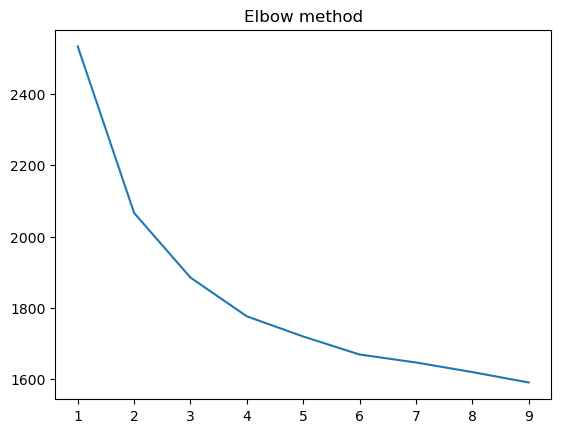

In [34]:
elbow_method(text_embeddings)

Let's say num_clusters = 3

In [35]:
def cluster(num_clusters, model_type):
    if model_type == "KMeans":
        model = KMeans(n_clusters=num_clusters)
    elif model_type == "Aglomerative":
        model = AgglomerativeClustering(n_clusters=num_clusters)
    elif model_type == "GM":
        model = GaussianMixture(n_components=31)
    
    clusters = model.fit_predict(text_embeddings)

    text_clusters = [set() for _ in range(max(clusters) + 1)]
    for i, label in enumerate(clusters):
        text_clusters[label].add(idx2paper_id[i])
    
    pca = PCA(n_components=2)
    reduced_embeddings = pca.fit_transform(text_embeddings)

    plt.figure(figsize=(15, 8))
    for cluster in range(num_clusters):
        plt.scatter(reduced_embeddings[clusters == cluster, 0], reduced_embeddings[clusters == cluster, 1], label=f"cluster {cluster+1}")
    plt.legend()
    plt.title(f"Text clusters after {model_type}, modularity is {modularity(G, text_clusters)} partition into {len(text_clusters)} clusters")
    plt.xlabel("PCA component 1")
    plt.ylabel("PCA component 2")
    plt.show()

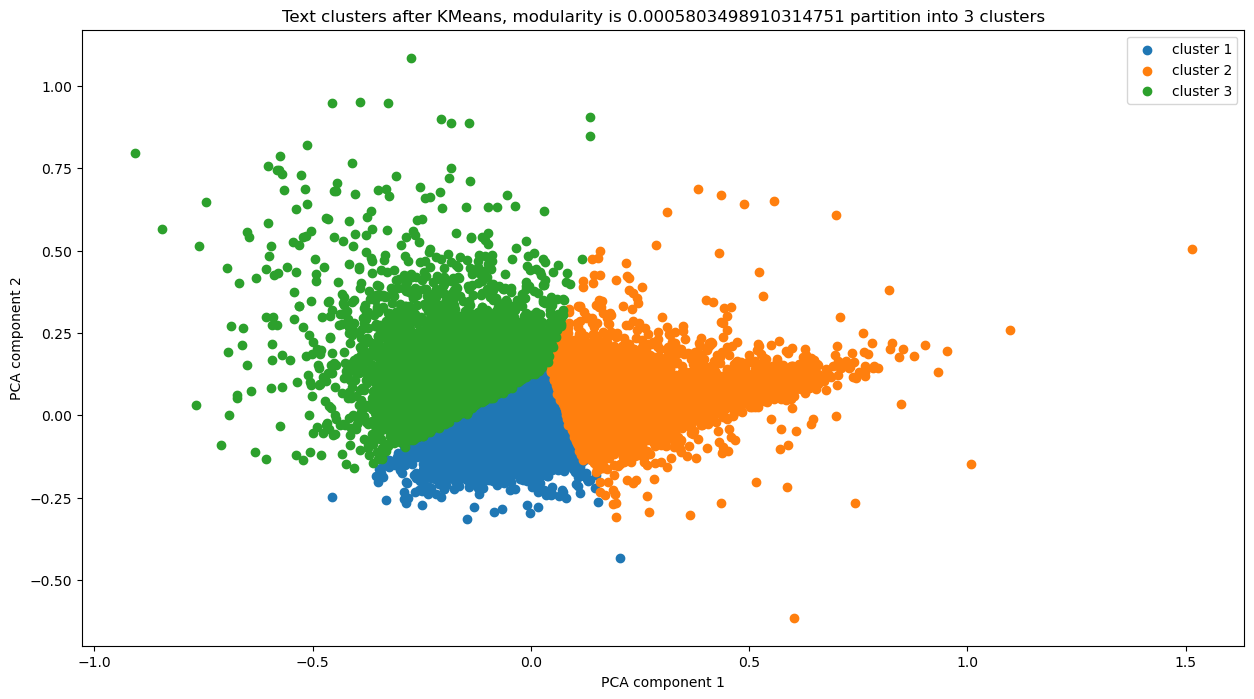

In [36]:
cluster(num_clusters=3, model_type="KMeans")

And now let's use the same clusters number as in louvain partition and compare the modularity 

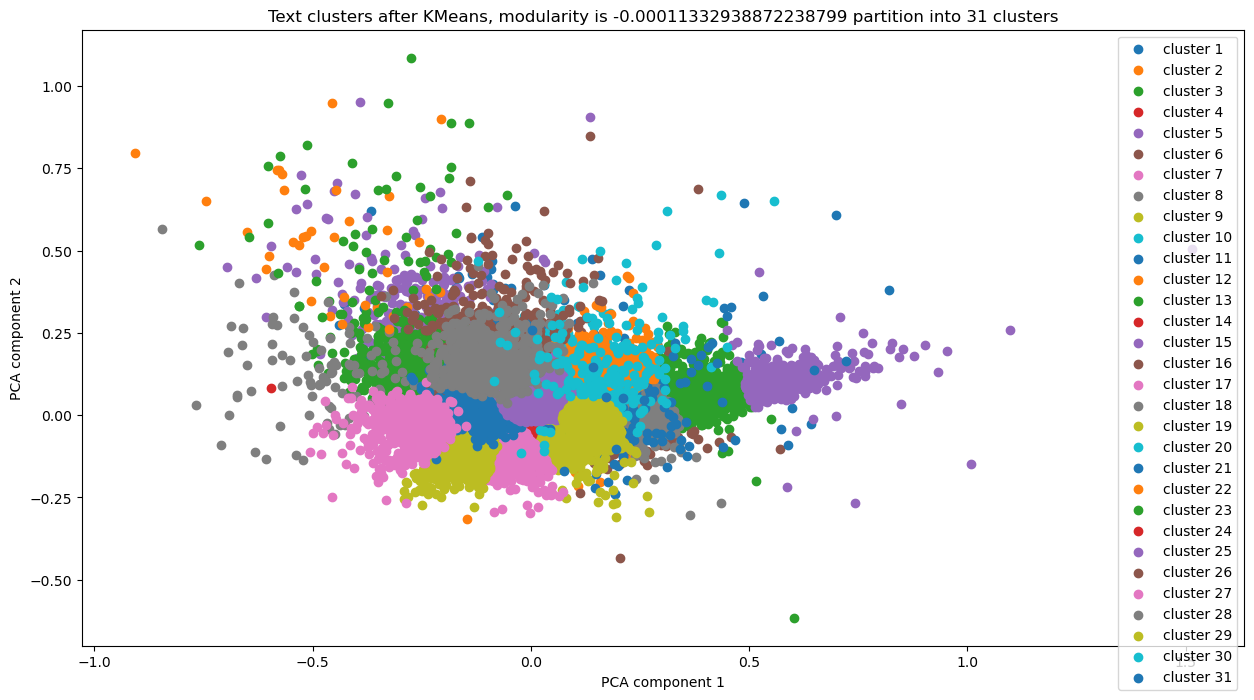

In [37]:
cluster(num_clusters=len(louvain_partition), model_type="KMeans")

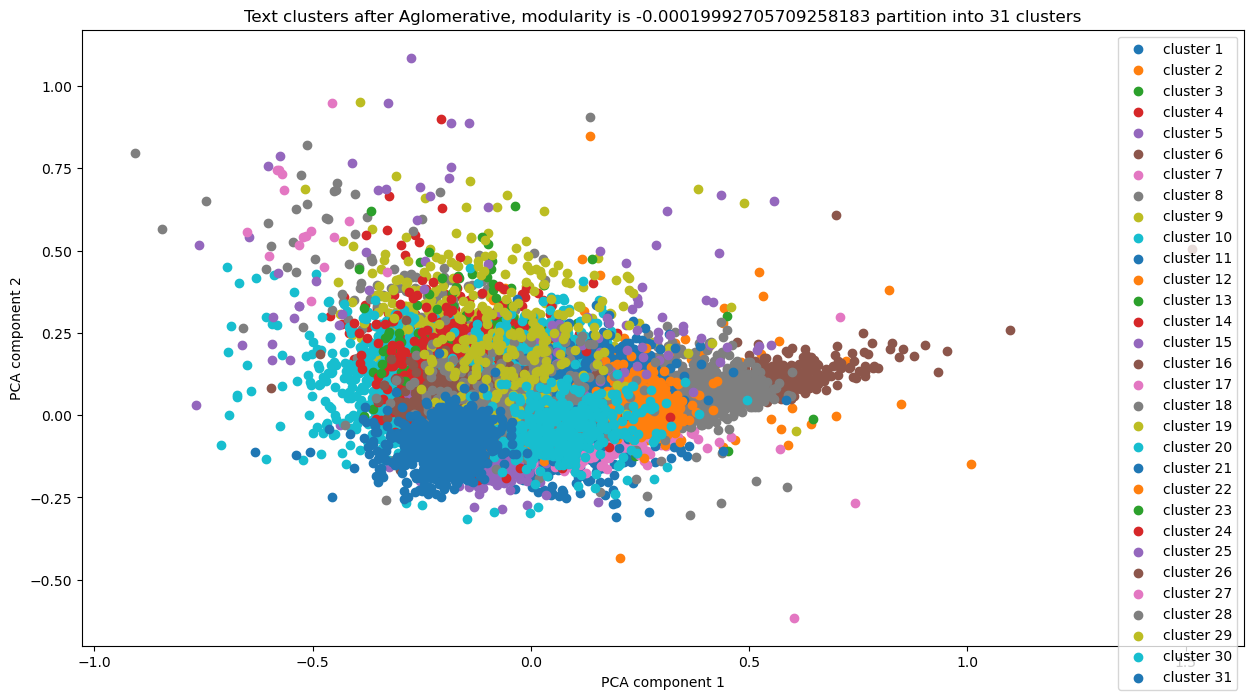

In [38]:
cluster(num_clusters=len(louvain_partition), model_type="Aglomerative")

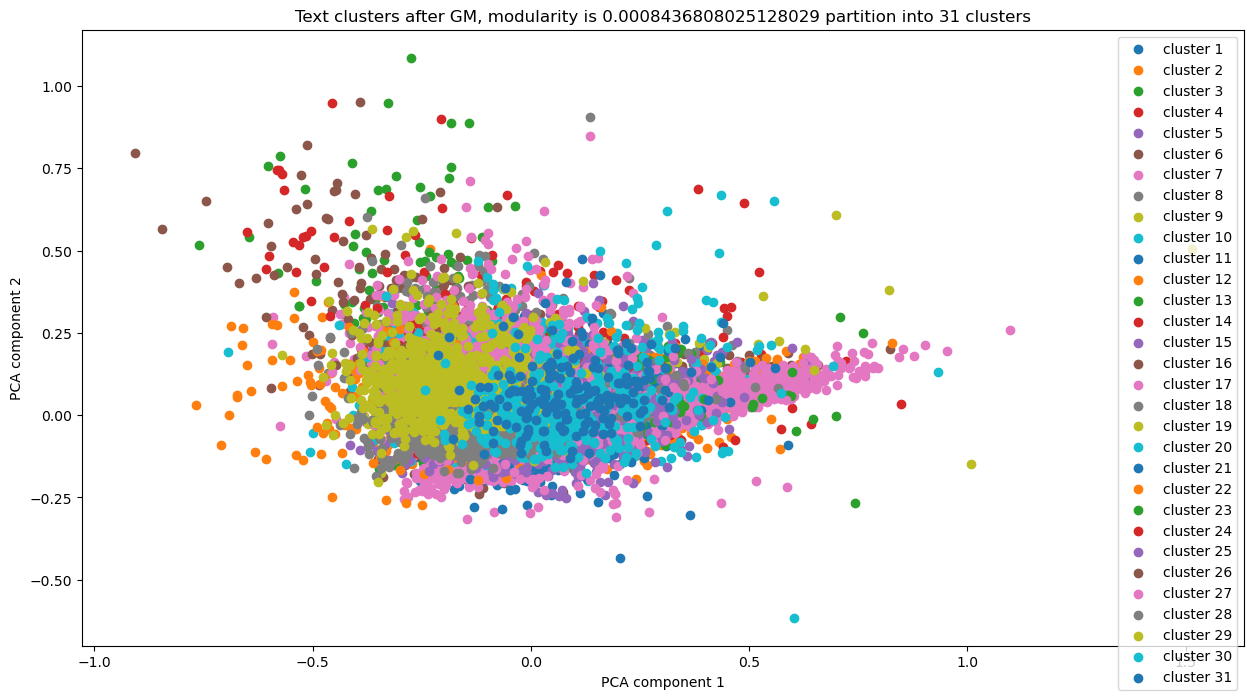

In [39]:
cluster(num_clusters=len(louvain_partition), model_type="GM")

Unsurprisingly, the modularity of this clustering method is poor. This is even good, because then the vertex cluster from the Louvain partitioning method will most likely differ from the vertex cluster obtained from textual considerations, and both of these labels can be added to the embedding of the vertex